In [ ]:
! pip install wget
import wget

url = 'https://github.com/dirkhovy/NLPclass/blob/master/data/reviews.xlsx?raw=true'
wget.download(url, 'reviews.xlsx')

'reviews (1).xlsx'

# Latent Dimensions I: Matrix Factorization

First, we need some data. Let's get a bunch of reviews

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# read in the data and transform it
df = pd.read_excel('reviews.xlsx', nrows=100000)
df = df[df.clean_text.isna()==False] # drop all reviews without clean text
documents = df.clean_text.apply(str).tolist() # make sure they are strings

In [ ]:
df.head()

,Unnamed: 0,category,text,clean_text
0,0,Beauty and Wellness,there was an issue with the delivery but this ...,issue delivery resolve quickly complete care s...
1,1,Computer & Accessories,i found the item i was looking for quickly on ...,find item look quickly web site place order to...
2,2,Bathroom,part ordered monday pm and received it next day .,order monday pm receive day
3,3,Cell phone Recycling,the day the phone was received i had the money...,day phone receive money bank
4,4,Flowers,"flowers were beautiful , delivered on time and...",flower beautiful deliver time notify progress ...


In [ ]:
df.category.value_counts()

Cell phone Recycling        21283
Flowers                     13828
Pets                        11210
Tires                       10250
Beauty and Wellness         10199
Fashion Accessories          9844
Batteries & Power Supply     6080
Bathroom                     5995
Gifts                        5687
Computer & Accessories       5597
Name: category, dtype: int64

In [ ]:
df[df['category']=='Pets'].text.iloc[6]

"i can not recommend this seller too highly , as prompt service at low price is the norm for a wide range of pet supplies . certainly the best and usually the cheapest for all staple products and medicines like flea & worm control . it 's not really worth anyone 's while using precious time trawling suppliers when animed is so consistently reliable and fair ."

In [ ]:
print(df.iloc[4].text)
print(df.iloc[4].clean_text)

flowers were beautiful , delivered on time and i was notified to the progress of my order at every step along the way .
flower beautiful deliver time notify progress order step way


In [ ]:
documents[0:10]

['issue delivery resolve quickly complete care shop aware',
 'find item look quickly web site place order tool couple min memory day 0st class delivery option special delivery',
 'order monday pm receive day',
 'day phone receive money bank',
 'flower beautiful deliver time notify progress order step way',
 'second time serenata flower pleased recent purchase thank',
 "n't know expect order keep fully date order",
 "glad n't result search engine cheap price buying experience mrmemory prove excellent product exactly describe fair price",
 'card past week good value money accompany sound delivery laptop definately use gizzmo heaven',
 'simple easy follow site provide extremely competitive price locate tire choose fitting day order minute']

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(99973, 2444)


## SVD

SVD decomposes the data into three components: the document view `U`, the singular values `S`, and the term view `V`.

In [ ]:
from sklearn.decomposition import TruncatedSVD # this also works with sparse matrices

# set number of latent components
k = 5

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

CPU times: user 685 ms, sys: 500 ms, total: 1.19 s
Wall time: 636 ms


In [ ]:
print(U.shape, S.shape, V.shape)

(99973, 5) (5,) (5, 2444)


In [ ]:
S

array([50.31098767, 31.33064677, 29.01458483, 26.77561937, 25.51755448])

## NMF

NMF provides only two components: the document view `W`, and the term view `H`.

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_

CPU times: user 4.5 s, sys: 793 ms, total: 5.29 s
Wall time: 4.45 s


In [ ]:
print(W.shape, H.shape)

(99973, 5) (5, 2444)


## Latent topics

We can use the term views `V` (from SVD) and `H` (from NMF) to describe the latent concept dimensions.

In [ ]:
import numpy as np
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A]) # for each row
    return [', '.join(t) for t in topic_words]


In [ ]:
V[0]

array([0.00493277, 0.00791205, 0.00510321, ..., 0.00509207, 0.00306121,
       0.00256642])

In [ ]:
np.argsort(t)

array([2366, 2115, 1775, ...,  878, 1353, 1937])

In [ ]:
t = V[0]
topn = 5
vocabulary = tfidf_vectorizer.get_feature_names()
[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]

# t[1937]
# t[2366]

['service', 'order', 'good', 'day', 'price']

Here are the terms from SVD:

In [ ]:
terms = tfidf_vectorizer.get_feature_names()

show_topics(V, terms)

['service, order, good, day, price',
 'phone, send, day, money, mazuma',
 'order, flower, deliver, day, arrive',
 'easy, use, easy use, website, flower',
 'service, flower, fast, excellent, delivery']

… and the ones from NMF

In [ ]:
show_topics(H, terms)

['good, price, good price, tyre, product',
 'phone, send, money, day, mazuma',
 'order, flower, deliver, day, arrive',
 'easy, use, easy use, website, quick',
 'service, great, fast, excellent, recommend']

## Visualization

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('spring') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
#     plt.legend()
    plt.show()

First, we create 3-dimensional document embeddings with both methods:

In [ ]:
low_dim_svd = TruncatedSVD(n_components=3)
low_dim_nmf = NMF(n_components=3, init='nndsvd')

# let's visualize only the first 200 documents
Z = X[:200]
categories = df.category[:200]

low_dim_U = low_dim_svd.fit_transform(Z)
low_dim_W = low_dim_nmf.fit_transform(Z)

Here is what SVD looks like:

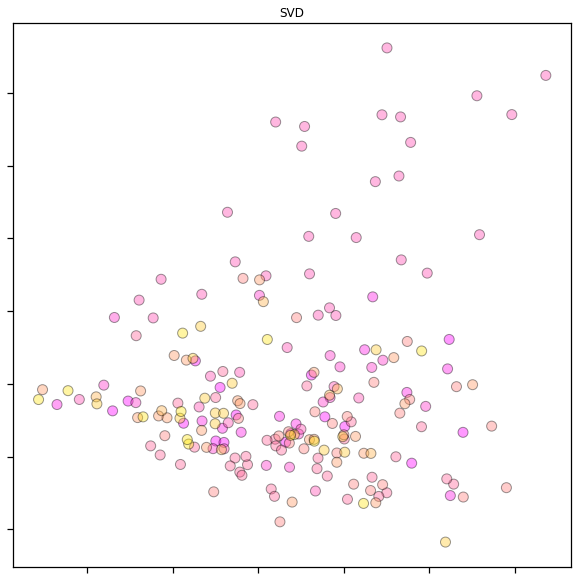

In [ ]:
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=2)

And here is NMF's version:

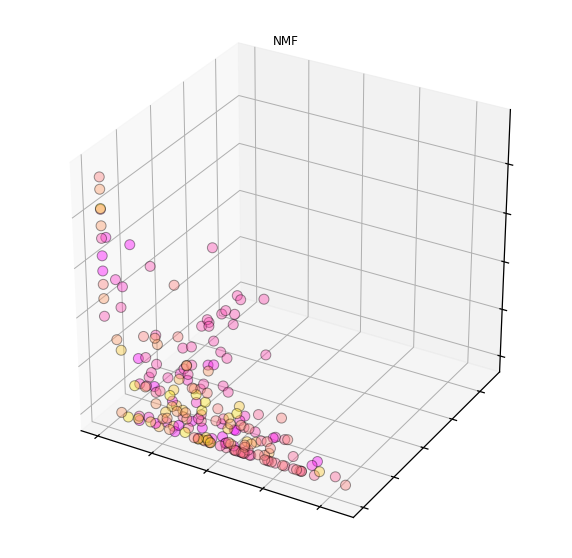

In [ ]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=3)

# Exercise

Plot data using TSNE

In [ ]:
from sklearn.manifold import TSNE

?TSNE

# Latent Dimensions II: Clustering

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering

k = 16

# reduce the dimensionality of the input, to speed up clustering
%time X2 = TruncatedSVD(n_components=300).fit_transform(X)

agg = AgglomerativeClustering(n_clusters=k)

CPU times: user 20.9 s, sys: 3.4 s, total: 24.3 s
Wall time: 16.5 s


Let's start clustering with a random sample of points:

In [ ]:
sample = np.random.choice(len(X2), replace=False, size=8000)
%time agg_sample_ids = agg.fit_predict(X2[sample])

CPU times: user 8.01 s, sys: 8.91 ms, total: 8.02 s
Wall time: 8.03 s


In [ ]:
agg_sample_ids

array([ 2,  1,  2, ..., 12,  4,  1])

We can get the best of both worlds by initializing k-means with centroids we found from agglomerative clustering. First, let's get the centroid/average of each cluster:

In [ ]:
X2[sample][agg_sample_ids == 4].mean(axis=0)

array([ 1.58182209e-01, -1.54284230e-02,  8.40584422e-02,  1.14228898e-03,
       -2.80381203e-02, -3.13000643e-02, -3.85449130e-02, -2.58742670e-02,
        9.56333973e-03,  5.81004730e-03, -4.88092559e-03,  1.24491041e-02,
       -1.82563422e-02,  1.60512423e-03,  1.28458646e-02,  1.57595064e-02,
        9.18976679e-03,  1.25642231e-03, -7.79805096e-03, -1.14991600e-02,
        3.15366018e-03,  5.65742257e-03,  8.59992760e-03, -8.72474276e-03,
       -5.29355414e-03,  2.80987614e-03, -3.67683471e-03,  7.01847252e-03,
       -2.61739403e-03, -1.99050763e-03,  4.79367225e-03,  4.03592667e-03,
        1.79712170e-03, -1.30419796e-04, -2.90734565e-03,  1.20018361e-03,
       -1.40903235e-03,  4.50062171e-03,  3.16447695e-05,  7.83469530e-03,
        2.22738654e-03,  2.73009606e-03, -1.99097550e-03, -2.78098935e-03,
        4.98722143e-03, -1.97653754e-03,  4.86855111e-03,  5.68530676e-03,
        3.00125131e-03,  1.42695566e-03, -1.46716672e-03, -3.37405526e-03,
        4.62558949e-03,  

In [ ]:
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

(16, 300)


In [ ]:
centroids

array([[ 1.79987724e-01, -6.48532157e-02, -7.43358087e-02, ...,
        -6.34717052e-04,  2.66302370e-03, -9.63857497e-04],
       [ 1.35599277e-01, -2.20213606e-02,  2.91565912e-03, ...,
         2.35658332e-04,  9.05545630e-04,  3.40713992e-04],
       [ 1.70183378e-01,  2.06266193e-01, -1.62775421e-02, ...,
        -2.58289820e-04, -9.85665597e-05,  4.24284367e-04],
       ...,
       [ 1.33094260e-01,  2.72215951e-02, -3.96069977e-02, ...,
        -8.31263079e-04,  8.40848212e-04,  3.11900876e-03],
       [ 1.33823435e-01, -2.11594641e-02,  2.02660170e-02, ...,
         3.98544816e-04,  3.86360444e-03, -5.11878532e-03],
       [ 1.30474288e-01, -1.18186920e-02,  2.10699052e-02, ...,
         1.88162831e-03,  9.76674858e-04,  6.69014990e-04]])

Now we can initialize the k-means algorithm with the agglomerative cluster centroids as starting points:

In [ ]:
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

# fit it on the full 300-dimensional data set
%time km.fit(X2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  """Entry point for launching an IPython kernel.


CPU times: user 358 ms, sys: 214 ms, total: 571 ms
Wall time: 6.17 s


KMeans(algorithm='auto', copy_x=True,
       init=array([[ 1.79987724e-01, -6.48532157e-02, -7.43358087e-02, ...,
        -6.34717052e-04,  2.66302370e-03, -9.63857497e-04],
       [ 1.35599277e-01, -2.20213606e-02,  2.91565912e-03, ...,
         2.35658332e-04,  9.05545630e-04,  3.40713992e-04],
       [ 1.70183378e-01,  2.06266193e-01, -1.62775421e-02, ...,
        -2.58289820e-04, -9.85665597e-05,  4.24284367e-04],
       ...,
       [ 1...
        -8.31263079e-04,  8.40848212e-04,  3.11900876e-03],
       [ 1.33823435e-01, -2.11594641e-02,  2.02660170e-02, ...,
         3.98544816e-04,  3.86360444e-03, -5.11878532e-03],
       [ 1.30474288e-01, -1.18186920e-02,  2.10699052e-02, ...,
         1.88162831e-03,  9.76674858e-04,  6.69014990e-04]]),
       max_iter=300, n_clusters=16, n_init=10, n_jobs=-1,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

We can now use the cluster IDs to plot the data in three dimensions:

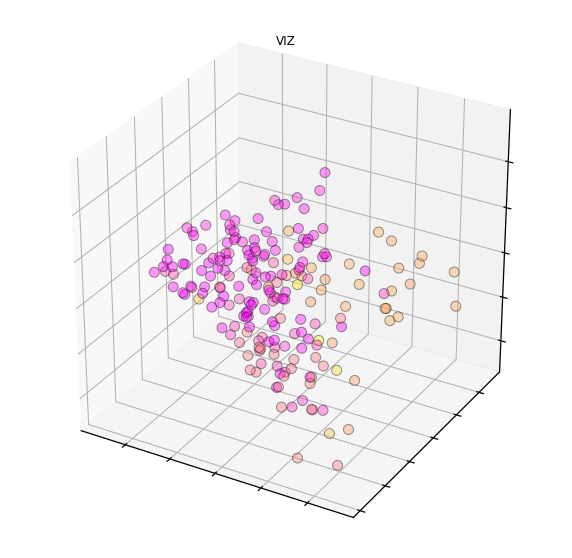

In [ ]:
plot_sample = np.random.choice(len(X2), replace=False, size=200)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

… and in two dimensions:

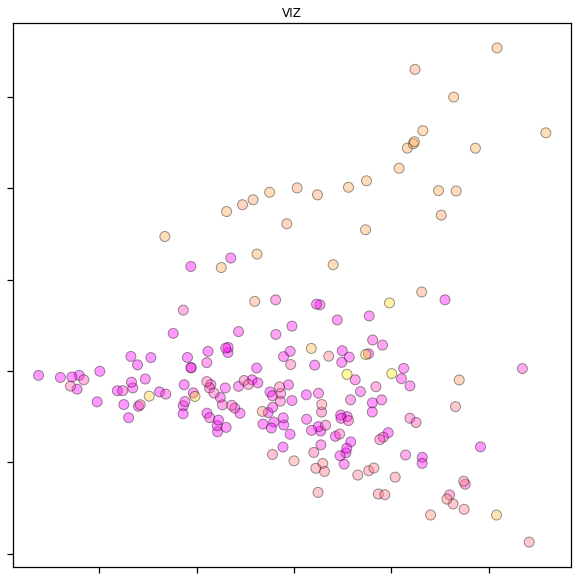

In [ ]:
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=2)

Compare that to the sample we used for agglomerative clustering:

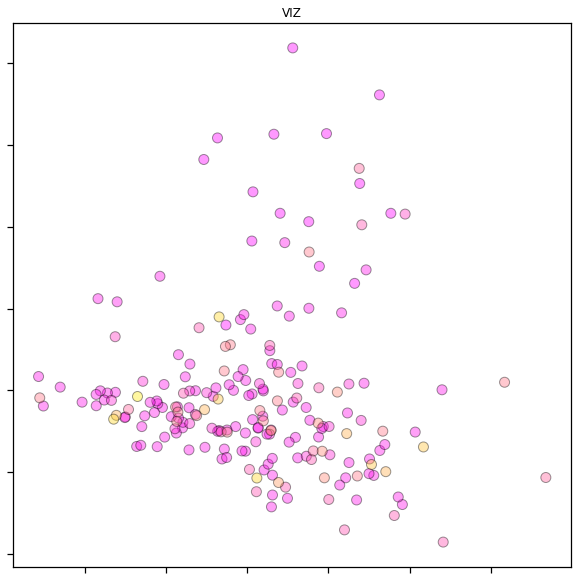

In [ ]:
plot_vectors(X2[sample[:200]], labels=agg_sample_ids[:200], dimensions=2)

## Evaluating clusters


20 0.01222299908687513
21 0.012886644505305531
22 0.013618170649987368
23 0.012932813785254613
24 0.012765376111541799
25 0.01307807713817201


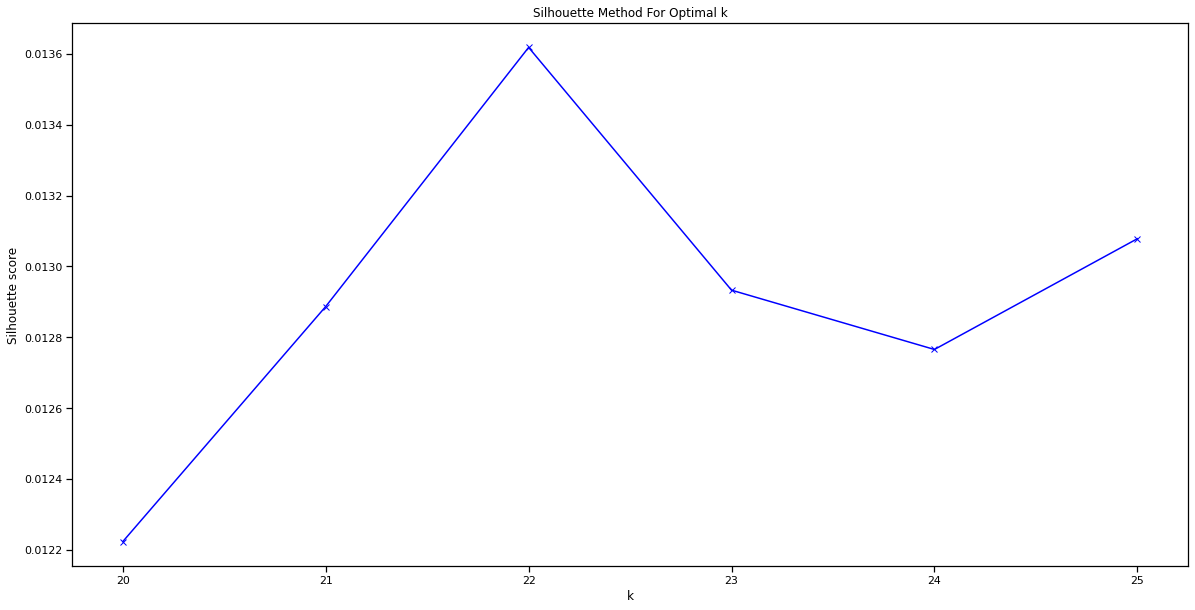

In [ ]:
from sklearn.metrics import silhouette_score

silhouettes = []

K = range(20, 26)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])
#     agg_centroids = np.array([X2[[i for i, v in enumerate(agg_cluster_ids) if v == k]].mean(axis=0) 
#                            for k in range(c)])

#     kmeans_clustering = KMeans(n_clusters=c, n_jobs=-1, init=agg_centroids)
#     kmeans_ids = kmeans_clustering.fit_predict(X2)
    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

## Clustering metrics

The [sklearn.metrics.cluster](
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.cluster) submodule contains evaluation metrics for cluster analysis results. There are two forms of evaluation:

- **supervised**, which uses a ground truth class values for each sample.
- **unsupervised**, which does not and measures the ‘quality’ of the model itself.


## Supervised Evaluation Metrics

V-measure can be used to compare the clustering results with the existing class labels of data points or with the alternative clustering. It is defined as the harmonic mean of **homogeneity** (h) and **completeness** (c) of the clustering:
$.$


<div>\[V_{\beta} = (1+\beta)\frac{h \cdot c}{\beta \cdot h + c}.\]</div>


In particular Rosenberg and Hirschberg (2007) define the following two desirable objectives for any cluster assignment:

- **homogeneity** (h): each cluster contains only members of a single class.
- **completeness** (c): all members of a given class are assigned to the same cluster.





<img src="https://image.slidesharecdn.com/clustering-180227115834/95/cluster-analysis-assignment-update-81-638.jpg?cb=1521519008" width="50%">


<img src="https://image.slidesharecdn.com/clustering-180227115834/95/cluster-analysis-assignment-update-82-638.jpg?cb=1521519008" width="50%">


### Import Data and Preprocessing


In [ ]:
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
X

## PCA


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca

In [ ]:
pca_transformed = pca.fit_transform(X_scaled)
pca_transformed

## Plot

In [ ]:
def plot3clusters(X, title, vtitle):
  plt.figure()
  colors = ['navy', 'turquoise', 'darkorange']
  lw = 2

  for color, i, target_name in zip(colors, [0, 1, 2], target_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=1., lw=lw,
                  label=target_name)
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)  
  plt.xlabel(vtitle + "1")
  plt.ylabel(vtitle + "2")
  plt.show()

In [ ]:
plot3clusters(pca_transformed[:,:2], 'PCA', 'PC')  

# Exercise

1. Compute SVD and NNMF on Iris dataset
2. Compute K-means and agglomerative clustering to obtain labels
3. For each combination, evaluate homogeneity, completeness and v_measure

Return a table with metrics and dimensionality reduction algorithm and clustering algorithm

In [ ]:
iris = datasets.load_iris()

In [ ]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
iris.target_names


array(['setosa', 'versicolor', 'virginica'], dtype='<U10')